# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [4]:
!apt-get -y install unzip wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpsl5 publicsuffix
Suggested packages:
  zip
The following NEW packages will be installed:
  libpsl5 publicsuffix unzip wget
0 upgraded, 4 newly installed, 0 to remove and 10 not upgraded.
Need to get 623 kB of archives.
After this operation, 1887 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpsl5 amd64 0.19.1-5build1 [41.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 publicsuffix all 20180223.1310-1 [97.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 wget amd64 1.19.4-1ubuntu2.2 [316 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 623 kB in 0s (1951 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libpsl5:a

In [5]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [6]:
!pip install pandas scikit-learn matplotlib

     |████████████████████████████████| 9.7 MB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 24.9 MB 29.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 27.2 MB 21.6 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 48.5 MB/s eta 0:00:01


## Рекуррентные нейронные сети

Рекуррентные нейронные сети (RNN) предназначены для работы с последовательностями (в том числе текстом). По устройству они похожи на цикл, где каждый шаг связан с предудущим. Работают RNN сильно дольше сверток, так как сверточные слои применяются независимо и можно параллельно вычислить все трансформации, а в RNN вычислять шаг можно только после того, как вычеслен предыдущий. Неэффективность, как правило, компенсируется точностью, поэтому RNN являются стандартным инструментом при работе с текстами.

Давайте посмотрим, как в торче использовать рекуррентные слои и как их соединять с Embedding и Linear слоями.

Для начала попробуем уже привычную классификацию новостей из ленты

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('lenta_sample.csv')

In [4]:
data.dropna(subset=['topic', 'text'], inplace=True)

Предобработка нам тут особо не важна.

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

Предобработка точно такая же

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [7]:
len(vocab)

670782

In [8]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
len(filtered_vocab)

55293

In [10]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens






In [13]:
MAX_LEN = 200

In [14]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [15]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [16]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [17]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [18]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

Есть несколько разновидностей рекуррентных слоев - RNN (vanila rnn), GRU, LSTM. 

Первый - самый простой рекуррентный слой, где на каждом шаге используется предыдущее состояние и текущий вектор, оба они умножаются на соответствующую матрицу весов и получившиеся вектора складываются в один, который передается на следующий шаг. Проблема с обычными RNN в том, что информация о предыдущих состояних очень быстро затирается и учитывать нелокальные зависимости не получается. 



LSTM и GRU частично решают это проблему добавление дополнительных матриц весов и активаций, которые будут отвечать за то, чтобы нужная информация сохранялась на протяжении всей последовательности. GRU немного проще и поэтому немного быстрее, но это не всегда значит, что LSTM лучше по качеству. 


In [19]:
# lstm cell
Image(url="https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png",
     width=1000, height=1000)

Ссылки, чтобы разобраться подробнее:  
    http://karpathy.github.io/2015/05/21/rnn-effectiveness/  
    https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21  
    https://colah.github.io/posts/2015-08-Understanding-LSTMs/  
    
    
    
    

Использовать RNN слой в torch достаточно просто при условии, что применяется общий паддинг (все обучающие данные до одной длины).
Нужно просто поставить его после другого слоя, который возвращает последовательность.
На выходе из vanila RNN  и GRU  мы получим два объекта - (output и h), а на выходе из LSTM - (output, (h, c)).
В output будут лежать скрытые состояния (h_t) на всех шагах последовательности. А в h - последнее скрытое состояние последовательности. У LSTM еще есть последнее внутреннее состояние c. На картинке выше видно, что он используется при расчете h, но внутри сети еще и передается между последовательностями отдельно. 

Для классификации мы можем использовать h, так как в нем накоплена вся информация о последовательности и можно уже к этому вектору применять софтмакс, чтобы получить вероятности классов.

In [20]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 50
        self.RNN_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # все три типа рнн слоев применяются почти одинаково
#         self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.rnn = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
#         self.rnn = nn.RNN(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        # применяем rnn слой
        rnn_output, (h, *_) = self.rnn(embedded)
        
        # lstm всегда будет возвращать трехмерный h
        # (1, 256, 128) - в текущем случае
        # от первой размерности нужно избавиться
        # для этого нужна функция squeeze(0) где ноль индекс размерности
        
        # для GRU или RNN эта строчка ничего не изменит и все будет работать
        h = h.squeeze(0)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [21]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.3700149035453797; F1 measure: 0.213359375
Loss: 2.3331090700626373; F1 measure: 0.212421875
Loss: 2.2547484000523883; F1 measure: 0.2358203125
Loss: 2.1554035997390746; F1 measure: 0.268388671875
Loss: 2.056787453174591; F1 measure: 0.3053515625
Eval -  0.5508159722222222
1
Loss: 1.2984862744808197; F1 measure: 0.60140625
Loss: 1.2393755167722702; F1 measure: 0.6197265625
Loss: 1.1944325002034506; F1 measure: 0.6339192708333333
Loss: 1.1523097196221352; F1 measure: 0.647744140625
Loss: 1.1127120413780212; F1 measure: 0.65971875
Eval -  0.7247150383141763
2
Loss: 0.8344336587190628; F1 measure: 0.7448046875
Loss: 0.8252625700831413; F1 measure: 0.74810546875
Loss: 0.8142835609118144; F1 measure: 0.7508984375
Loss: 0.7989979486167431; F1 measure: 0.754453125
Loss: 0.7850586802363396; F1 measure: 0.7583828125
Eval -  0.7666343390804599
3
Loss: 0.6430188620090485; F1 measure: 0.7987109375
Loss: 0.6335504747927189; F1 measure: 0.8025
Loss: 0.6356003288427988; F1 measure: 0.8020312

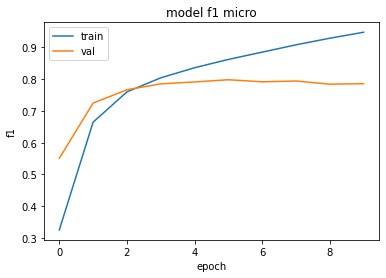

In [22]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
max(f1s_eval)

0.7981764846743296

Основной параметр в RNN слое - units. Чем он больше, тем больше весов будет в модели. Он будет соответствовать размеру вектора состояния. 

Рекуррентные слои можно накладывать друг на друга. В торче проще всего это сделать указав параметр num_layers - он автоматически создаст нужное количество слоев и соединит их между собой. Если num_layers > 1, то в output будут скрытые состояния с последнего слоя, а вот в h - будут последние состояния со всех слоев. Последнее состояние последнего слоя можно выбрать из обоих по индексу.


Также можно просто добавить несколько слоев отдельно и передавать в следующий output из предыдущего. Это позволяет создавать слои с разным параметром units (num_layers создает слое и одним и тем же параметром).




In [25]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 50
        self.RNN_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, num_layers=3, 
                           batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        # применяем rnn слой
        rnn_output, (h, *_) = self.rnn(embedded)
        # тут тоже будет трехмерный h
        # но первый будет не 1 а равный num_layers
        # мы возьмем последний с помощью индекса -1
        # squeeze(0) тут не нужен и его и не получится применить
        output = self.act(self.fc(h[-1]))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [26]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.3617623233795166; F1 measure: 0.2179296875
Loss: 2.334479993581772; F1 measure: 0.21482421875
Loss: 2.300838855902354; F1 measure: 0.21990885416666667
Loss: 2.2364641678333284; F1 measure: 0.23462890625
Loss: 2.1687480256557463; F1 measure: 0.2551015625
Eval -  0.3497910680076628
1
Loss: 1.7937491714954377; F1 measure: 0.384921875
Loss: 1.7583761912584306; F1 measure: 0.402421875
Loss: 1.7272389276822409; F1 measure: 0.41765625
Loss: 1.6929814237356187; F1 measure: 0.43291015625
Loss: 1.6524979219436646; F1 measure: 0.4494375
Eval -  0.5580244252873563
2
Loss: 1.3534621369838715; F1 measure: 0.5637890625
Loss: 1.347797576189041; F1 measure: 0.5688671875
Loss: 1.3199949526786805; F1 measure: 0.5770572916666666
Loss: 1.295353894531727; F1 measure: 0.584501953125
Loss: 1.2750313370227813; F1 measure: 0.59059375
Eval -  0.6372778975095785
3
Loss: 1.0782435339689256; F1 measure: 0.6580859375
Loss: 1.0622646456956863; F1 measure: 0.66775390625
Loss: 1.0449156379699707; F1 measure: 

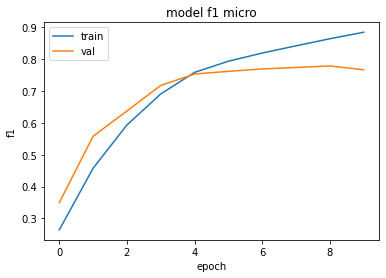

In [27]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
max(f1s_eval)

0.7783758381226054

### Bidirectional

Рекурретную сеть можно применить в прямом и обратном порядке и объединить состояния в одно (половина вектора будет про инфу до, половина про инфу после). Это назвается bidirectional. Можно превратить слой в двунаправленный параметром bidirectional=True или же отдельно подать в слой сначала прямую последовательность, а потом перевернутую (а выходы сконкатенировать). 


Для простой классификации (когда мы используем только последний стейт) первый способ не очень-то поможет (т.к. на последнем стейте у нас будет только первый стейт с обратного прохода). 

А вот если мы развернем последовательность (второй способ), то последним окажется стейт, соответствующий первому слову в тексте. Когда мы объединим его с вектором из прямого прогона, то получится полная информация с двух направления.


NB: когда мы указываем bidirectional=True, то этот слой применяется и напрямую и обратно. Поэтому в отдельном применении к перевернутой последовательности я тоже использую один слой. Но кажется, что логичнее иметь один слой для прямого прогона и один для обратного.

In [29]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 50
        self.RNN_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # через параметр делается вот так, а в forward будет точно также как в сетке выше
#         self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, num_layers=1, 
#                            batch_first=True, bidirectional=True)
        
        #через разворот входной последовательности
        self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, num_layers=1, 
                           batch_first=True)
        
        # bidirectional создает 2 вектора размерности unit, соответственно на следующем слое умножаем размерность на 2
        self.fc = nn.Linear(self.RNN_UNITS*2, output_dim)
        
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        embedded_backward = torch.flip(embedded, (1, ))
        
        # применяем rnn слой напрямую и в обратную
        rnn_output, (h, *_) = self.rnn(embedded)
        rnn_output_backward, (h_backward, *_) = self.rnn(embedded_backward)
        
        # у нас 1 слой и для lstm мы также добавляем squeeze(0)
        h, h_backward = h.squeeze(0), h_backward.squeeze(0)
        
        # конкатим последнии стейты
        rnn_output_bidirectional = torch.cat([h, h_backward], 1) # 2 - номер dim по которому конкатим
        output = self.act(self.fc(rnn_output_bidirectional))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [30]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.3372486877441405; F1 measure: 0.2190234375
Loss: 2.206665351986885; F1 measure: 0.26642578125
Loss: 2.0734622244040173; F1 measure: 0.3178125
Loss: 1.9476312279701233; F1 measure: 0.364375
Loss: 1.8403240699768066; F1 measure: 0.4031328125
Eval -  0.6114715038314176
1
Loss: 1.2095031917095185; F1 measure: 0.6300390625
Loss: 1.166721830368042; F1 measure: 0.644375
Loss: 1.1288194676240286; F1 measure: 0.6559505208333334
Loss: 1.0938479445874691; F1 measure: 0.667470703125
Loss: 1.06243725669384; F1 measure: 0.676671875
Eval -  0.7259925766283525
2
Loss: 0.8171924716234207; F1 measure: 0.7472265625
Loss: 0.8103998801112176; F1 measure: 0.7501171875
Loss: 0.7957117237647374; F1 measure: 0.7546875
Loss: 0.7849208126962185; F1 measure: 0.75771484375
Loss: 0.7740571024417877; F1 measure: 0.7604765625
Eval -  0.7663876915708813
3
Loss: 0.6426291182637215; F1 measure: 0.7962109375
Loss: 0.6469307927787304; F1 measure: 0.79453125
Loss: 0.6388481957713763; F1 measure: 0.796692708333333

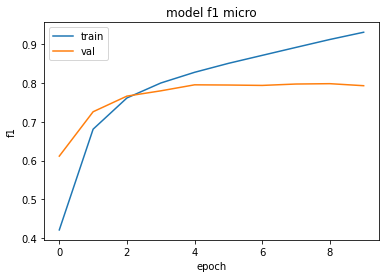

In [31]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
max(f1s_eval)

0.7984644396551724

## Pack и Pad

До этого момента расхождение между torch и tf для RNN было минимальным, касающимся только логики самого языка. Проблема в том, что rnn на торче, обычно пишутся по-другому. В торче иначе подходят к обработке последовательностей разной длины.

Выше мы делали общий паддинг, чтобы иметь возможность создать Tensor. Однако при общем паддинге получается, что через RNN будет пропускаться много нулевых элементов последовательности. И чем больше максимальная длина последовательностей отличается от средней, тем больше будет этих лишних нулей в тензоре. В торче можно передавать в RNN слои последовательности разной длины. Сложность в том, что в батче длины все равно должны быть одинаковые.

В торче есть специальный формат для rnn, который называется packed sequence, который упаковывает последовательности в куски одинаковой длины, которые можно напрямую передавать в RNN слои.

**Full Disclosure**: Не могу сказать, что я до конца понял, как это работает. Туториалов по торчу слишком мало и сам формат какой-то неоправданно усложненный. По крайней мере оно работает. 

Нужно немного переписать Dataset и train и validation лупы. 

В датасете нужно удалить все пустые последовательности, потому что они несовместимы с пакингом. 

Изменения в train/evaluate значительнее, смотрите комментарии ниже.

In [33]:


class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # чтобы у нас был цельный тензор мы все еще делаем общий паддинг
        # Можно было бы убрать ограничение MAX_LEN в 200, 
        # но обучаться будет все-таки дольше даже с пакингом, поэтому оставим так
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)

        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.target = torch.LongTensor(targets)
        
        
        # в texts из-за фильтрованного словаря может получиться пустая последовательность
        # когда мы ниже будем делать pack-pad это приведет к ошибке
        # и вообще обучаться на нулях не очень
        # поэтому отфильтруем texts и targets с ненулевыми последовательностями в texts
        self.target = self.target[self.texts.sum(1).bool()] #сумма по dim=1 будет ненулевая(=True) если есть 1 ненулевой индекс
        self.texts = self.texts[self.texts.sum(1).bool()] 
        self.length = len(self.texts)
        

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens



def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()
        
        # У нас есть тензор с общим паддингом/т.е. лишними нулями
        # чтобы преобразовать такой тензор в оптимальный (packed) формат 
        # нам нужны изначальный длиный этих последовательностей (без нулей).
        # Эту инфу легко восстановить из самого тензора - 
        # заменяем все значения на True/False (нули будут False)
        # и суммируем (True равнозначен единице)
        # Сумма True будет равна длине последовательности без нулей
        lengths = texts.bool().sum(1)
        
        # теперь нужно отсортировать тензор по убыванию длин последовательностей
        # функция .sort - вернет сами отсортированные длины и индексы, с помощью которых
        # можно также отсортировать тензор с текстами и таргетами (чтобы они сходились)
        length_sorted, perm_index = lengths.sort(0, descending=True)
        texts, ys = texts[perm_index], ys[perm_index]
        
        
        predictions = model(texts.to(device), length_sorted.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:
            # тут все также как и в функции выше
            lengths = texts.bool().sum(1)
            length_sorted, perm_index = lengths.sort(0, descending=True)
            texts, ys = texts[perm_index], ys[perm_index]
            
            
            predictions = model(texts.to(device), length_sorted.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)

Пересоздаем датасет с измененным классом

In [34]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True, )

valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=1024, shuffle=True)

Теперь самое сложное

Определение слоев остается таким же как и раньше. Но нужно сильно поменять forward. 

С входящими данными нужно сделать следующее - прогнать тензор с общим паддингом через ембеддинг слой, упаковать последовательность эмбедингов, чтобы убрать нули, прогнать packed последовательность через rnn, распаковать выход rnn в тензор с общим паддингом, выбрать стейт соответствующий последнему ненулевому индексу в каждой последовательности.  

Смотрите в код и комментарии, чтобы понять, где что.

In [35]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.LSTM_UNITS = 128

        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.rnn = nn.LSTM(self.EMB_DIM, self.LSTM_UNITS, num_layers=1, bidirectional=True,
                            batch_first=True) 

        self.fc = nn.Linear(self.LSTM_UNITS*2, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
#     def embedding_masking(self, 
#                           x,
#                           pad_mask,
#                           value: float = 0.):
#         x = x.masked_fill((~(pad_mask.bool())).unsqueeze(-1), value)
#         return x
    
    
    # теперь нам еще нужны длины последовательностей, добавляем их аргументом
    def forward(self, text, lengths):
        
        # эмбедим как обычно
        embedded = self.embedding(text)
        
        
        # теперь используем torch.nn.utils.rnn.pack_padded_sequence
        # чтобы упаковать последовательности
        # для упаковывания нужны длины (lengths)
        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded,
                                                                  lengths.cpu(), 
                                                                  batch_first=True)

        # rnn слои могут работать с таким форматом сразу
        # поэтому тут никаких изменений
        rnn_output, (h, *_) = self.rnn(packed_embedded)
        
        
        # используем pad_packed_sequence чтобы вернуть упакованные последовательности
        # к обычным тензорам
        # дополнительный параметр тут - максимальная длина последовательности до которой
        # нужно добавить нулей (мы можем взять ее из изначального тензора с общим паддингом)
        # text имеет размерность (batch_size, max_len); size(1) вытащит max_len
        unpacked_rnn_output, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_output,
                                                                        total_length=text.size(1),
                                                                        batch_first=True)
        
        
        # теперь самая запутанная часть!
        # Мы восстановили тензор из запакованной последовательности
        # и на последних состояних у нас могут быть нули (если длина последовательности меньше max_len)
        # Поэтому для каждой последовательности нам нужно достать состояние 
        # соответствующее ее последнему ненулевому токену
        # Получить индекс последнего ненулевого элемента не сложно - это просто длина (которая у нас уже есть) минус 1
        # минус 1 нужен т.к. индексы начинаются с нуля
        
        # НО в торче нельзя достать элемент как в numpy - X[:, lengths-1]
        # нужно создать маску и использовать функцию .gather 
        # вот тут есть визиуализация как она работает - 
        # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms
        
        # Не уверен, что я понимаю, что происходит ниже
        # Но оно работает правильно
        # Для всех последовательностей в батче выбирается 1 вектор состояния,
        # соответствующий последнему ненулевому элементу
        
        
        # изначально lengths - одномерный
        # создаем ему искусственные размерности через unsqueeze
        # получим (256, 1, 1)
        mask = (lengths-1).unsqueeze(1).unsqueeze(1)
        
        # теперь нужно расширить маску чтобы было (256, 1, 256)
        # т.е. маска будет захватывать 1 полный вектор для всех последовательностей
        mask = mask.expand((unpacked_rnn_output.size(0), 1, unpacked_rnn_output.size(2)))
        
        # теперь накладываем маску на unpacked_rnn_output
        # результат будет трехмерный
        # но одна размерность будет 1 и ее можно убрать через squeeze
        # получиться (batch_size, hidden_size)
        lh = unpacked_rnn_output.gather(1, mask).squeeze(1)
        
        
        # ну и дальше все также
        hidden = self.fc(lh)
        outputs=self.act(hidden)
        
        return outputs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [36]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.3831879353523253; F1 measure: 0.21904296875
Eval -  0.3236781529017857
1
Loss: 1.8424859702587129; F1 measure: 0.3822265625
Eval -  0.4840262276785714
2
Loss: 1.372575581073761; F1 measure: 0.566435546875
Eval -  0.6146937779017857
3
Loss: 1.0586782974004745; F1 measure: 0.681552734375
Eval -  0.6886509486607143
4
Loss: 0.8514716416597367; F1 measure: 0.744794921875
Eval -  0.7217145647321428
5
Loss: 0.702330869436264; F1 measure: 0.786552734375
Eval -  0.7543422154017857
6
Loss: 0.6021782660484314; F1 measure: 0.8147265625
Eval -  0.7556849888392857
7
Loss: 0.5182842272520065; F1 measure: 0.840732421875
Eval -  0.7697056361607143
8
Loss: 0.4490975624322891; F1 measure: 0.86158203125
Eval -  0.7579520089285714
9
Loss: 0.39140950292348864; F1 measure: 0.88099609375
Eval -  0.7763846261160714


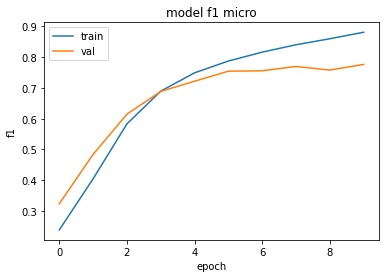

In [37]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
max(f1s_eval)

0.7763846261160714

# Sequence labelling

Бывают задачи, когда нужно предсказать какой-то класс каждому элементу последовательности. Это называется sequence labelling (разметка последовательности). Под этот паттерн попадает предсказание части речи, определение именованных сущностей, определение опечаток и т.п.

Выше мы использовали h (последний стейт), а теперь нужно взять output.

Возьмем данные opencorpora

In [48]:
!wget http://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig.nonmod.xml.zip 

--2021-06-04 11:51:01--  http://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig.nonmod.xml.zip
Resolving opencorpora.org (opencorpora.org)... 46.4.87.221
Connecting to opencorpora.org (opencorpora.org)|46.4.87.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7164759 (6.8M) [application/zip]
Saving to: ‘annot.opcorpora.no_ambig.nonmod.xml.zip’

annot.opcorpora.no_ 100%[===================>]   6.83M  22.1MB/s    in 0.3s    

2021-06-04 11:51:01 (22.1 MB/s) - ‘annot.opcorpora.no_ambig.nonmod.xml.zip’ saved [7164759/7164759]



In [49]:
!unzip annot.opcorpora.no_ambig.nonmod.xml.zip

Archive:  annot.opcorpora.no_ambig.nonmod.xml.zip
  inflating: annot.opcorpora.no_ambig.nonmod.xml  


In [50]:
!pip install lxml

In [39]:
from lxml import etree
from collections import defaultdict

In [40]:
open_corpora = etree.fromstring(open('annot.opcorpora.no_ambig.nonmod.xml', 'rb').read())

Преобразуем в более удобный формат.

In [41]:
sents = []
labels = []


for sentence in open_corpora.xpath('//tokens'):
    length = len(sentence.xpath('token'))
    ended = False
    sent = []
    label = []
    for i,token in enumerate(sentence.xpath('token')):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        
        if (i+1)==length and gram_info[0] == 'PNCT':
            gram_info = ['SENT']
            ended = True
        
            
        sent.append(word[0])
        label.append(gram_info[0])
    sents.append(sent)
    labels.append(label)

        

Пример данных

In [42]:
list(zip(sents[0], labels[0]))

[('«', 'PNCT'),
 ('Школа', 'NOUN'),
 ('злословия', 'NOUN'),
 ('»', 'PNCT'),
 ('учит', 'VERB'),
 ('прикусить', 'INFN'),
 ('язык', 'NOUN')]

In [43]:
# словарь
vocab = Counter()

for sent in sents:
    vocab.update([x.lower() for x in sent])

In [44]:
# тут словарь не очень большой и тут нужно предсказывать нужно часть речи для всего
# поэтому не будем фильтровать словарь
len(vocab)

54634

In [45]:
# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

In [46]:
id2word = {i:word for word, i in word2id.items()}

В отличие от простой классификации тут нужно предсказывать последовательность классов. Для обучения нужно закодировать классы точно также как и тексты

In [47]:
tags = set()
for seq in labels:
    tags.update(seq)

label2id = {'PAD':0}
for tag in tags:
    label2id[tag] = len(label2id)

    
id2label = {i:l for l, i in label2id.items()}
tags = [id2label[i] for i in range(len(label2id))]

И паддить также нужно и тексты и таргеты, чтобы длины у них совпадали

In [48]:
MAX_LEN = max(len(s) for s in sents)

In [49]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, label2id, MAX_LEN, texts, labels):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w.lower()] for w in t][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        self.targets = [torch.LongTensor([label2id[l] for l in seq][:MAX_LEN]) for seq in labels]
        self.targets = torch.nn.utils.rnn.pad_sequence(self.targets, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.label2id = label2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
    
    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.targets[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [50]:
BATCH_SIZE = 256

In [51]:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(sents, labels, test_size=0.05)

In [52]:
training_set = Dataset(word2id, label2id, MAX_LEN, train_texts, train_labels)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, )

In [53]:
valid_set = Dataset(word2id, label2id, MAX_LEN, valid_texts, valid_labels)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

Для сравнения сначала обучим сеть только с помощью Dense слоев.

In [54]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device))
        loss = criterion(predictions.permute(0, 2, 1), ys.to(device))
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}')
        
    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.permute(0, 2, 1), ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())
            
    return np.mean(epoch_loss)

Не будем делать пакинг, чтобы было попроще

In [55]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.LSTM_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.rnn = nn.LSTM(self.EMB_DIM, self.LSTM_UNITS, num_layers=1, bidirectional=True,
                            batch_first=True) 

        
        self.fc = nn.Linear(self.LSTM_UNITS*2,output_dim)
        self.act = nn.LogSoftmax(2) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.rnn(embedded)
        hidden = self.fc(rnn_output)
        outputs=self.act(hidden)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

Ф-меру тут расчитать будет сложнее, поэтому пока просто посчитаем лосс, а в конце сделаем общую ф-меру

In [56]:
losses = []
losses_eval = []

for i in range(10):
    print(i)
    losses.append(train(model, training_generator, optimizer, criterion, 30))
    losses_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.575894824663798
Loss: 0.3530729463944832
Loss: 0.27161992482013175
1
Loss: 0.08987584536274275
Loss: 0.08617440412441889
Loss: 0.08291676135526763
2
Loss: 0.06852500326931477
Loss: 0.06616999277224143
Loss: 0.06410420549412568
3
Loss: 0.05456961207091808
Loss: 0.05416192971169949
Loss: 0.05310431623624431
4
Loss: 0.04675999681154887
Loss: 0.04601671596368154
Loss: 0.044871056121256615
5
Loss: 0.03987998552620411
Loss: 0.03890239285926024
Loss: 0.03783602499299579
6
Loss: 0.033493749673167865
Loss: 0.03269342494507631
Loss: 0.03208171038164033
7
Loss: 0.02867095023393631
Loss: 0.02804863496373097
Loss: 0.027490093807379403
8
Loss: 0.0247644929215312
Loss: 0.02418655725196004
Loss: 0.023728503100574016
9
Loss: 0.021308195715149244
Loss: 0.02092552436515689
Loss: 0.020674644514090484


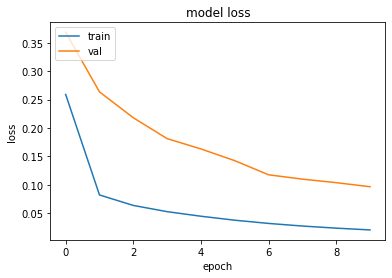

In [57]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Лучше конечно еще оценивать правильность всей последовательности, но пока сделаем только поэлементную оценку.

In [58]:
from sklearn.metrics import classification_report

In [59]:
# предсказываем весь валидационный сет
pred = model(valid_set.texts.to(device)).argmax(2).detach().cpu()

In [60]:
# сплющиваем последовательности классов в 1 последовательность и 
# считаем метрики как будто это обычная классификация
print(classification_report(valid_set.targets.reshape(-1), pred.reshape(-1), labels=list(range(len(tags))),
                                                                             target_names=tags,
                                                                             zero_division=0))

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00     66659
        INFN       0.59      0.33      0.43       222
        TIME       0.00      0.00      0.00         2
        PRTF       0.00      0.00      0.00        74
        ADVB       0.74      0.75      0.74       280
        INTJ       0.00      0.00      0.00        26
        NUMB       0.79      0.78      0.79       318
        PRTS       0.00      0.00      0.00        83
        UNKN       0.31      0.15      0.20       288
        COMP       0.00      0.00      0.00        23
        LATN       0.70      0.45      0.55       207
        SENT       0.99      1.00      1.00      1111
        Prnt       0.00      0.00      0.00         0
        PNCT       0.99      1.00      1.00      1499
        VERB       0.63      0.73      0.67       939
        SYMB       0.00      0.00      0.00        16
        NPRO       0.92      0.94      0.93       282
        CONJ       0.97    

# Предсказание/Inference

После оценки часто хочется посмотреть как будет работать модель на каких-то отдельных примерах. Для этого нужно воспрозвести весь пайплайн и прогонять через него нужный текст.

In [61]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    
    # в тф тут мы должны были еще думать а паддинге
    # но в торче на единичных примерах падить не нужно
    ids = [word2id.get(token.lower(), 0) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label):
    # декодирует индексы в части речи
    pred = pred.argmax(2)[0].numpy()

    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model(torch.LongTensor([ids]))
    labels = pred2tags(pred, id2label)
    
    return list(zip(tokens, labels))

In [62]:
model.to('cpu')

Clf(
  (embedding): Embedding(54635, 100)
  (rnn): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=30, bias=True)
  (act): LogSoftmax(dim=2)
)

In [63]:
label_seq('Какой-то новый текст для проверки работы.', word2id, id2label, MAX_LEN, model)

[('Какой', 'ADJF'),
 ('-', 'PNCT'),
 ('то', 'CONJ'),
 ('новый', 'ADJF'),
 ('текст', 'NOUN'),
 ('для', 'PREP'),
 ('проверки', 'NOUN'),
 ('работы', 'NOUN'),
 ('.', 'PNCT')]

Выглядит неплохо!